**Tutorial 8 - Markov Chain Monte Carlo**

In this tutorial we will learn how to construct a basic Metropolis-Hastings Markov Chain (MCMC) sampler and apply it to type Ia supernova data.

We will use the same supernova data we used before.  There is a nonlinear relationship between redshift and distance modulus within the standard cosmological model.  In practice it would be better to solve this problem by a non-linear $\chi^2$ fit because there are few parameters, but we will do it by MCMC as an exercises.  

 1) Make a Metropolis-Hastings stepping function.

 The function should take the following inputs: 
 x - a numpy vector giving the current position in parameter space
 
 loglike - the value of the log of the likelihood 
           evaluated at x
           
 loglike_func() - a function that returns the log of the 
            likelihood given a position in parameters space
            
 proposal_func() - a proposal function that takes a position in 
                  parameter space and returns another point

 The function should return the updated position, the updated 
 loglike at that position and a Boolean that is True if the proposed step was 
 accepted and False if it was not. 
 You can assume the proposal function is symmetric, 
i.e. $q(x | y) = q(y | x)$

Call the function MH_step()

In [105]:
import numpy as np
import warnings
#from functools import lru_cache

#this store the i-1 value returned from the function to make this faster
#not in this case(second try was ok not this)
#@lru_cache(maxsize=2)
def MH_step(p,loglike,loglike_func,proposal_function):
    '''
    Metropolis-Hastings Monte Carlo Step
    p = position 
    '''

    #new position to be evalueted
    updated_p = proposal_function(p)
    #print(updated_p)
    #updated loglike in new position
    updated_loglike = loglike_func(updated_p)

    #alpha parameter 
    warnings.filterwarnings('ignore')
    alpha = min(1,np.exp(updated_loglike-loglike))
    

    #condition over alpha
    check = np.random.uniform(0.,1.,size=1)

    if(alpha <= 1. and alpha > check):        
        return updated_p,updated_loglike,True
        
    elif(alpha <= 1. and alpha < check):
        return p, loglike, False
    
    #not really a real condition but non si sa mai
    elif(alpha == 1.):
        return updated_p,updated_loglike,True     



2) Now you must make a *class* for a Gaussian proposal function called 
"gaussian_proposal_class".  The class should have a constructor that takes the standard deviation of the proposal in each dimension.  This is done by defining a \_\_init\_\_ function within it.  You should be able to call an instance of this class like a function by defining a \_\_call\_\_ function.

In [106]:
# Complete this code for a Gaussian proposal function class

#class gaussian_proposal_class :
    ## This part is the constructor and 
    ## sets the internal information in the object
    # that is declared with
    # "func = gaussian_proposal_function(sigma_vector)"
#    def __init__(self, sigma_step):
#        self.n = len(sigma_step)
#        self.sigma_step = sigma_step
#
    ##  This part defines what happens when 
    ##  you do "y = func(params)"
    ##  This should return a new point
#    def __call__(self,params):
#        return ________________
#
# Once this class is defined:
#
# example of creating a instance of this class
# gpf = gaussian_proposal_class(sigma)
#
# using it after it has been created
# result = gpf(params)



In [107]:
class gaussian_proposal_class:
    
    def __init__(self, sigma_step):
        '''
        sigma_step = max of how much u want to move in each direction
        params = coordintes of the point
        return 2 value, x and y but in the same array
        '''
        self.n = len(sigma_step)
        self.sigma_step = sigma_step

    def __call__(self,params):

        #params[0] = np.random.normal(params[0],self.sigma_step[0],size=1)
        #params[1] = np.random.normal(params[1],self.sigma_step[1],size=1)
        #x_t = params+self.sigma_step*np.random.normal(params, self.n, size = self.n)
        x_t = params+self.sigma_step*np.random.normal(0, 1, size = self.n)
        #x_t = np.array((params[0], params[1]))
        #print(x_t)
        return x_t 

sigma = [1, 0.1]
test = gaussian_proposal_class(sigma)

ok = test([20,.2])
print(ok)


[19.12273932  0.10293055]


In [108]:
# 3) Make a Gaussian likelihood class that stores the data and errors and 
# returns the log likelihood as a default function.

#class LogGaussianLikelihood :
#    def __init__(self,y_data,x_data,y_model,sigmas):
#    
#         Store the data, model and errors in the object.
#         The function y_model(params,x_data) will return the 
#         predicted value for y to be compared to y_data for 
#         any input vectors params and x_data.  This does not 
#         need to be specified here.
#
#    def __call__(self,params):
#         This is the prior range on Omega matter
#        if(params[1] < 0 or params[1] > 1) return -1.0e100
#        
#        Using the stored data and model and the input parameters 
#        to calculate the log of the Gaussian likelihood and return 
#        its value.
#        

In [109]:
class LogGaussianLikelihood:
    def __init__(self, y_data,x_data,y_model,sigmas):
        '''
        y_data = parametro da acchiappare
        y_data = modulo di distanza
        x_data = redshift
        MODEL == universe DL
        '''
    
        self.x = x_data
        self.y = y_data
        self.model = y_model
        self.sigma = sigmas
    
    def __call__(self, params):
        '''
        params = [normalisation factor, omega matter]

        -- calcolo della loglike di un modulo di distanza dato
        -- il modello e l'errore 
        -- quindi alla fine è sul modello che faccio le considerazioni
        FUNZIONE VALE SOLO PER UN PUNTO ALLA VOLTA
        '''        
        #omega matter condition
        if(params[1]<0. or params[1]>1.):
           return -1e100
           
        else:            
        #expected values of distance
            dist_mod = self.model(params,self.x)

            log_like = -0.5* np.sum(((self.y-dist_mod)/self.sigma)**2)
        
        return log_like 


4) Write a function that returns the distance modulus with 
signature def mu_model(p,z). 

Where parameters p are:

p[0] is the absolute magnitude normalization 

p[1] is omega_matter.

z is the redshift.

Use the library function 
astropy.cosmology.FlatLambdaCDM.luminosity_distance(z).value 
to calculate the luminosity distance.  This is a nonlinear function of the omega_matter.


In [110]:
#from astropy.cosmology import FRW
import astropy.cosmology as cosmo


def mu_model(p,z):
    cos = cosmo.FlatLambdaCDM(70,p[1])
   
    return 5*np.log10(cos.luminosity_distance(z).value)+p[0]


5) Read in the supernova data from SCPUnion2.1_mu_vs_z.txt and plot it.

In [111]:

import pandas as pd

data = pd.read_table('SCPUnion2.1_mu_vs_z.txt', comment='#')

z = np.array(data['redshift'])
mu = np.array(data['dist_mod'])
sigma = np.array(data['dist_mod_error'])

#print(data.columns)


 6) Make an instance of LogGaussianLikelihood with the data.  Call it loglike_func

Make an instance of gaussian_proposal_function

Set up the initial point p[] and its log likelihood 
 using  loglike_func(p)

Make an MCMC loop 1000 steps or more long and make a scatter plot of  the chain.  Record the acceptance fraction.


In [112]:
#init the chain == guess point in parameter space
#possibly a low prob one
#initial = [m0, mu]

import matplotlib.pyplot as plt

loglike_function =  LogGaussianLikelihood(mu,z,mu_model,sigma)


N = 2000

step = np.array([0.02,0.05])

initial = np.array([24.,0.6])

initial_l = loglike_function(initial)

prop_func = gaussian_proposal_class(step)

print('test for the MH chain', '\n')
print( 'likelihood of inital point: ',initial_l)
print('proposed step: ',prop_func(initial))
print('loglike in proposed point: ', loglike_function(prop_func(initial)))





test for the MH chain 

likelihood of inital point:  -12396.99545138154
proposed step:  [24.01301418  0.53956981]
loglike in proposed point:  -12731.073310915388


In [113]:
point = np.zeros([N,2])
point[0] = initial

LogLike = np.zeros(N)
LogLike[0] = initial_l

#print(len(point[:,1]))

conditions = []


for i in range(1,N):
    point[i], LogLike[i], condition = MH_step(point[i-1],LogLike[i-1],loglike_function,prop_func)
    conditions.append(condition)

#this is a mask just like 'conditions    
not_conditions = [not x for x in conditions]


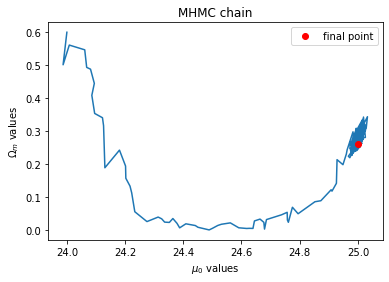

number of accepted points: 383
acceptance percentage: 19.15 %

 number of accepted points, without the burn-in: 327

 number of discarded points: 1616


In [114]:
import itertools

accepted = np.array(list(itertools.compress(point,conditions)))

plt.plot(accepted[:,0], accepted[:,1])
plt.plot(point[-1,0], point[-1,1], color='r',linestyle='none',marker='o', label='final point')
plt.title('MHMC chain')
plt.xlabel('$\mu_0$ values')
plt.ylabel('$\Omega_m$ values')
plt.legend()
plt.show()


print('number of accepted points:', len(accepted))

print('acceptance percentage:', len(accepted[:,0])/len(point[:,0] ) *100, '%')

#remove the burn in
accepted = accepted[np.where(accepted[:,0] > 24.96)]

discarded = np.array(list(itertools.compress(point,not_conditions)))



print('\n','number of accepted points, without the burn-in:',len(accepted))
print('\n', 'number of discarded points:', len(discarded))




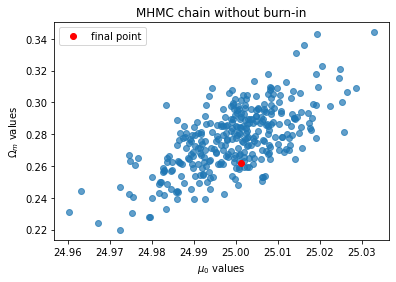

In [115]:
#plt.plot(accepted[:,0], accepted[:,1],linestyle='none', marker='.')
plt.scatter(accepted[:,0], accepted[:,1], alpha=.7)
plt.plot(point[-1,0], point[-1,1], color='r',linestyle='none',marker='o', label='final point')
plt.xlabel('$\mu_0$ values')
plt.ylabel('$\Omega_m$ values')
plt.title('MHMC chain without burn-in')

plt.legend()
plt.show()




7) Make historgrams of the two parameters.

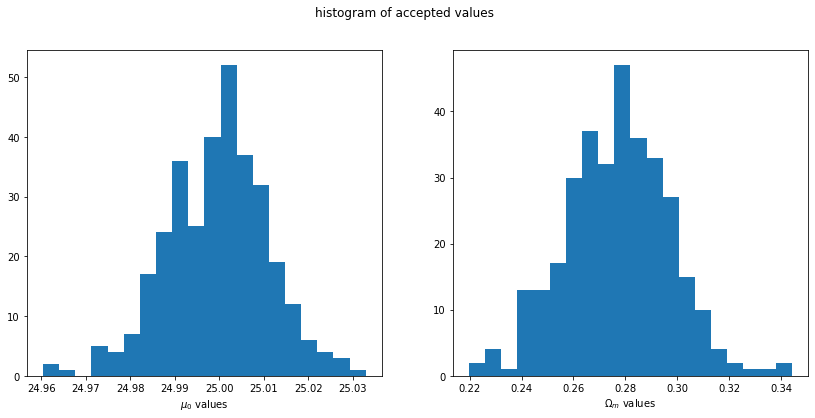

In [116]:
fig,(ax1, ax2) =plt.subplots(1,2, figsize=(14,6))

plt.suptitle('histogram of accepted values')

ax1.hist(accepted[:,0], bins=20)
ax1.set_xlabel('$\mu_0$ values')


#ax1.hist(discarted[:,0], bins=20, color='orange')

ax2.hist(accepted[:,1], bins=20)
ax2.set_xlabel('$\Omega_m$ values')

#plt.title('histogram of accepted values')
fig.show()

8) Use plt.hist2d() to make a 2 dimensional histogram of the chain with labels.

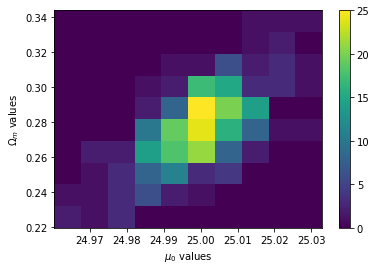

In [117]:
plt.hist2d(accepted[:,0], accepted[:,1], bins=10, cmap='viridis')

plt.xlabel('$\mu_0$ values')
plt.ylabel('$\Omega_m$ values')
plt.colorbar()
plt.show()

 9) I have written a function with just a few lines missing that returns the cross-correlation function between two vectors with lag m.
 
 Use this function to estimate the correlation length 
 of your chain. Plot the auto-correlation function for 
 lags of zero to a few hundred.
 
 What is the correlation length of your chain?

In [118]:
def corrfunction(x,y):
    '''
    This function calculates the correlation coefficient 
    as a function of lag between 
    '''
    xc = x - np.mean(x)
    yc = y - np.mean(y)
    
    N = len(x)
    out = np.empty(N-2)
    stdx = np.std(xc)
    stdy = np.std(yc)

    for i in range(N-2) :
        xt = xc[0:N-i]
        yt = yc[i:N]
        if(stdx == 0 or stdy == 0):  ## this can happen for last elements
            out[i] = 0
        else :
            out[i] = np.mean(xt*yt)

    out /= (stdx*stdy)
    return out

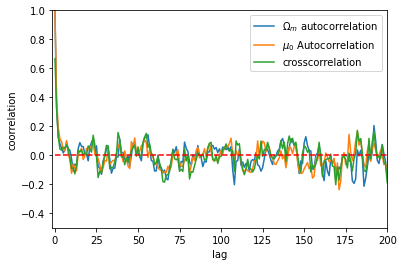

In [119]:
#togli il burn-in

corr = corrfunction(accepted[:,0],accepted[:,1])

corr00 = corrfunction(accepted[:,0],accepted[:,0])

corr11 = corrfunction(accepted[:,1],accepted[:,1])

lag = np.arange(0,len(accepted)-2)

plt.plot(lag, corr11, label='$\Omega_m$ autocorrelation')
plt.plot(lag, corr00, label='$\mu_0$ Autocorrelation')
plt.plot(lag, corr, label='crosscorrelation')
plt.legend()
plt.hlines(0,0,300, linestyles='--',color='r')

plt.xlim((-1.5,200))
plt.ylim((-.5,1))

plt.xlabel('lag')
plt.ylabel('coorrelation')
plt.show()

10) Calculate the mean, variance and normalized covariance of the parameters.  For a flat universe, $\Omega_m + \Omega_\Lambda = 1$ where $\Omega_\Lambda$ is the density of the cosmological constant.  What are the mean value and "1 sigma" error bars on  $\Omega_\Lambda$.

In [120]:
cov = np.cov(accepted[:,0], accepted[:,1])

#correlation matrix from tutorial 2
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

corr = correlation_from_covariance(cov)

print('covariance matrix:', '\n')
print(cov)
print()
print('correlation matrix:' '\n')
print(corr)
print()
print('mean of omega matter = ',np.mean(accepted[:,1]),'+/-', np.sqrt(cov[1,1]))
print('mean of mu 0 = ',np.mean(accepted[:,0]),'+/-', np.sqrt(cov[0,0]))
print('dens =', corr[0,1])

covariance matrix: 

[[0.00013159 0.00015482]
 [0.00015482 0.00040965]]

correlation matrix:

[[1.         0.66683497]
 [0.66683497 1.        ]]

mean of omega matter =  0.27713672539256123 +/- 0.02023985882014636
mean of mu 0 =  24.99944575764641 +/- 0.011471092602203596
dens = 0.6668349689303397


save the result as a csv file

In [121]:
data = {
    'mu':accepted[:,0],
    'omega':accepted[:,1]
}

df = pd.DataFrame(data)

df.to_csv('tut9data.csv')